In [47]:
import xgboost as xgb
import h5py,numpy as np

In [48]:

with h5py.File('trainData/sig.h5', 'r') as sigipt,h5py.File('trainData/bkg.h5', 'r') as bkgipt:
    trainData = np.append(bkgipt['train'][:],sigipt['train'][:])
    sig = sigipt['train'][:]
    bkg = bkgipt['train'][:]

In [49]:
label = ['E1Norm','E2Norm','t12','Qedep','chisquare','nCap','nMichel','michelDist','edepR','nDist']

In [50]:
import pandas as pd
df = pd.DataFrame(data=trainData)
df.shape
df = df.dropna()
df.shape
x = df.values[:,:-1]
y = np.array([int(i) for i in df.values[:,-1]])
sigtrain = x[y==1]
sigtag = y[y==1]
bkgtrain = x[y==0]
bkgtag = y[y==0]

In [51]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

In [7]:
dtrain = xgb.DMatrix( xtrain, label=ytrain,feature_names=label)
dtest = xgb.DMatrix( xtest, label=ytest,feature_names=label)
sigtrainM = xgb.DMatrix(sigtrain, label=sigtag,feature_names=label)
bkgtrainM = xgb.DMatrix(bkgtrain, label=bkgtag,feature_names=label)

In [8]:
weightT = np.ones(ytrain.shape)
weightT[ytrain==0] = 50
dtrainweight = xgb.DMatrix( xtrain, label=ytrain,feature_names=label,weight=weightT)

In [9]:
dbstweightD10 = xgb.train({'max_depth':10}, dtrainweight)

In [8]:
weight20T = np.ones(ytrain.shape)
weight20T[ytrain==0] = 20
dtrainweight20 = xgb.DMatrix( xtrain, label=ytrain,feature_names=label,weight=weight20T)
dbstweight20D10 = xgb.train({'max_depth':10}, dtrainweight20)

In [9]:
def acc(pred,truth,threshold):
    bkgpred = pred[truth==0][pred[truth==0]<threshold]
    bkg = truth[truth==0]
    sigpred = pred[truth==1][pred[truth==1]>=threshold]
    sig = truth[truth==1]
    print('bkg acc: {}/{}, {:.5f};sig acc: {}/{},{:.5f}'.format(bkg.shape[0]-bkgpred.shape[0],bkg.shape[0],bkgpred.shape[0]/bkg.shape[0],sigpred.shape[0],sig.shape[0],sigpred.shape[0]/sig.shape[0]))

In [13]:
acc(dbstweight20D10.predict(dtrainweight20),ytrain,0.98)

bkg acc: 0/112084, 1.00000;sig acc: 2536/6782,0.37393


In [16]:
acc(dbstweight20D10.predict(dtest),ytest,0.98)

bkg acc: 2/47907, 0.99996;sig acc: 1134/3036,0.37352


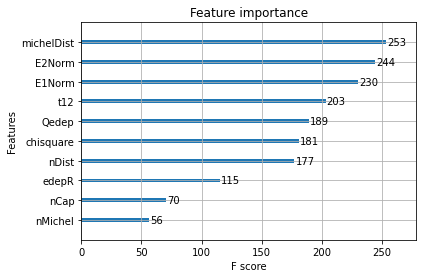

In [36]:
xgb.plot_importance(dbstweight20D10)

In [17]:
dbstweight20D7 = xgb.train({'max_depth':7}, dtrainweight20)

In [18]:
acc(dbstweight20D7.predict(dtrainweight20),ytrain,0.96)

bkg acc: 0/112084, 1.00000;sig acc: 1830/6782,0.26983


In [19]:
acc(dbstweight20D7.predict(dtest),ytest,0.8)

bkg acc: 4/47907, 0.99992;sig acc: 957/3036,0.31522


In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [51]:
model = XGBClassifier(max_depth=12)
n_estimators = range(10, 30, 10)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x, y)

/opt/gentoo/usr/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:20:35] WARNING: xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.054330 using {'n_estimators': 20}
-0.071990 (0.001998) with: {'n_estimators': 10}
-0.054330 (0.002658) with: {'n_estimators': 20}


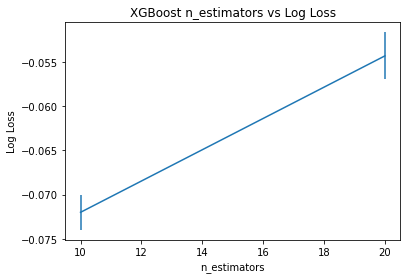

In [54]:
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

In [20]:
dbstweight20D12 = xgb.train({'max_depth':12}, dtrainweight20)

In [28]:
acc(dbstweight20D12.predict(dtrainweight20),ytrain,0.975)

bkg acc: 0/112084, 1.00000;sig acc: 2735/6782,0.40327


In [27]:
acc(dbstweight20D12.predict(dtest),ytest,0.975)

bkg acc: 1/47907, 0.99998;sig acc: 1211/3036,0.39888


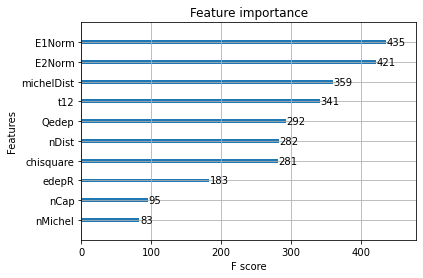

In [29]:
xgb.plot_importance(dbstweight20D12)

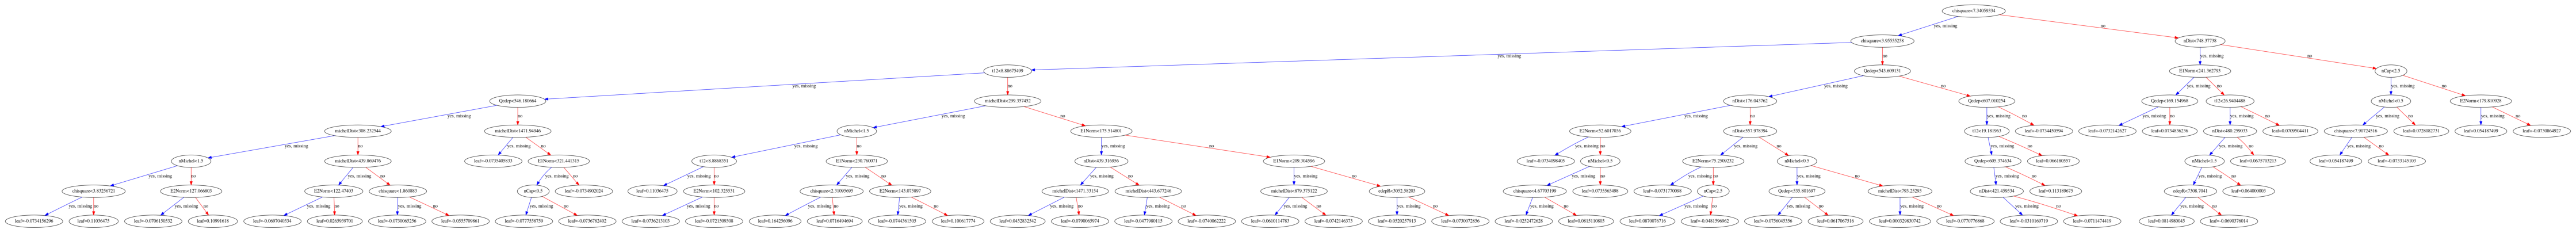

In [39]:
fig, ax =plt.subplots(figsize=(80,16))
xgb.plot_tree(dbstweight20D7, num_trees=2,ax=ax)
plt.savefig('20D7.png')

In [ ]:
dbstweight20D12N12 = xgb.train({'max_depth':12}, dtrainweight20,num_boost_round)

In [52]:
dbstweight20D12cv = xgb.cv({'max_depth':12}, dtrainweight20,num_boost_round=10,nfold=10)

In [53]:
dbstweight20D12cv.mean()

train-rmse-mean    0.122043
train-rmse-std     0.000099
test-rmse-mean     0.129637
test-rmse-std      0.000977
dtype: float64

In [54]:
dbstweight20D12cv

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.350954,0.000016,0.351501,0.000122
1,0.246912,0.000026,0.248247,0.000295
2,0.174485,0.000033,0.176881,0.000469
3,0.124385,0.000053,0.128275,0.000594
4,0.090091,0.000075,0.095914,0.000776
5,0.067112,0.000108,0.075232,0.001108
6,0.052149,0.000122,0.062632,0.001395
7,0.042823,0.000152,0.055642,0.001602
8,0.037331,0.000182,0.051953,0.001704
9,0.034186,0.000220,0.050093,0.001705


In [33]:
import matplotlib.pyplot as plt

In [40]:
dbstweight20D8 = xgb.train({'max_depth':8}, dtrainweight20)

In [41]:
acc(dbstweight20D8.predict(dtrainweight20),ytrain,0.975)

bkg acc: 0/112084, 1.00000;sig acc: 2138/6782,0.31525


In [44]:
acc(dbstweight20D8.predict(dtest),ytest,0.9)

bkg acc: 4/47907, 0.99992;sig acc: 1054/3036,0.34717


In [ ]:
fig, ax =plt.subplots(figsize=(160,40))
xgb.plot_tree(dbstweight20D12,ax=ax)
plt.savefig('20D12.png')

In [23]:
dbstweight20D6 = xgb.train({'max_depth':6}, dtrainweight20,num_boost_round=30)

In [26]:
acc(dbstweight20D6.predict(dtrainweight20),ytrain,0.8)

bkg acc: 0/112024, 1.00000;sig acc: 2466/6842,0.36042


In [25]:
acc(dbstweight20D6.predict(dtest),ytest,0.8)

bkg acc: 2/47967, 0.99996;sig acc: 1014/2976,0.34073


In [32]:
dbstweight20D8 = xgb.train({'max_depth':8}, dtrainweight20,num_boost_round=30)

In [44]:
acc(dbstweight20D8.predict(dtrainweight20),ytrain,0.935)

bkg acc: 0/112024, 1.00000;sig acc: 2656/6842,0.38819


In [43]:
acc(dbstweight20D8.predict(dtest),ytest,0.935)

bkg acc: 1/47967, 0.99998;sig acc: 1098/2976,0.36895
